<a href="https://colab.research.google.com/github/Tinabike/Projektarbeit-PyGMTSAR/blob/main/Campi_Flagrei_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import platform, sys, os
if 'google.colab' in sys.modules:
    # install PyGMTSAR stable version from PyPI
    !{sys.executable} -m pip install -q pygmtsar
    # alternatively, install PyGMTSAR development version from GitHub
    #!{sys.executable} -m pip install -Uq git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar
    # use PyGMTSAR Google Colab installation script to install binary dependencies
    # script URL: https://github.com/AlexeyPechnikov/pygmtsar/blob/pygmtsar2/pygmtsar/pygmtsar/data/google_colab.sh
    import importlib.resources as resources
    with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
        !sh {google_colab_script_filename}
    # enable custom widget manager as required by recent Google Colab updates
    from google.colab import output
    output.enable_custom_widget_manager()
    # initialize virtual framebuffer for interactive 3D visualization; required for headless environments
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)
    display.start()

# specify GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

# display PyGMTSAR version
from pygmtsar import __version__
__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources

'2024.8.30.post5'

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import joblib
import dask
from dask.distributed import Client
import warnings
import pyvista as pv
import panel
from contextlib import contextmanager
import matplotlib.pyplot as plt
from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles, XYZTiles

warnings.filterwarnings('ignore')


In [3]:
# plotting modules
pv.set_plot_theme("document")
panel.extension(comms='ipywidgets')
panel.extension('vtk')

@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

S1_249398_IW3_20230111T170554_VV_8DAC-BURST
S1_249398_IW3_20230123T170554_VV_5D0F-BURST
S1_249398_IW3_20230204T170553_VV_500B-BURST
S1_249398_IW3_20230216T170553_VV_F39F-BURST
S1_249398_IW3_20230228T170553_VV_792E-BURST
S1_249398_IW3_20230312T170553_VV_E04F-BURST
S1_249398_IW3_20230324T170553_VV_77E1-BURST
S1_249398_IW3_20230405T170553_VV_6819-BURST
S1_249398_IW3_20230417T170554_VV_A360-BURST
S1_249398_IW3_20230429T170554_VV_16D3-BURST
S1_249398_IW3_20230511T170555_VV_AE0D-BURST
S1_249398_IW3_20230523T170556_VV_89D7-BURST
S1_249398_IW3_20230604T170556_VV_E5EF-BURST
S1_249398_IW3_20230616T170557_VV_0F4D-BURST
S1_249398_IW3_20230628T170557_VV_1CA7-BURST
S1_249398_IW3_20230710T170558_VV_886B-BURST
S1_249398_IW3_20230722T170559_VV_5EBC-BURST
S1_249398_IW3_20230803T170600_VV_CB81-BURST
S1_249398_IW3_20230815T170600_VV_B7B8-BURST
S1_249398_IW3_20230827T170601_VV_3E88-BURST
S1_249398_IW3_20230908T170602_VV_BA43-BURST
S1_249398_IW3_20230920T170602_VV_5F80-BURST
S1_249398_IW3_20231002T170602_VV_0F48-BURST
S1_249398_IW3_20231014T170602_VV_9BC4-BURST
S1_249398_IW3_20231107T170602_VV_2695-BURST
S1_249398_IW3_20231119T170602_VV_4548-BURST
S1_249398_IW3_20231201T170601_VV_622B-BURST
S1_249398_IW3_20231213T170601_VV_4B2A-BURST
S1_249398_IW3_20231225T170600_VV_5900-BURST



In [4]:
ORBIT = 'A'
SUBSWATH = 1
REFERENCE = '2024-07-23'

BURSTS = """
S1_092601_IW1_20241027T165748_VV_5F6D-BURST
S1_092601_IW1_20241015T165748_VV_2AC2-BURST
S1_092601_IW1_20241003T165747_VV_B3A3-BURST
S1_092601_IW1_20240921T165747_VV_5E04-BURST
S1_092601_IW1_20240909T165747_VV_6A6E-BURST
S1_092601_IW1_20240828T165746_VV_66D6-BURST
S1_092601_IW1_20240816T165746_VV_3343-BURST
S1_092601_IW1_20240804T165746_VV_7271-BURST
S1_092601_IW1_20240723T165746_VV_C44C-BURST
S1_092601_IW1_20240711T165747_VV_75B2-BURST
S1_092601_IW1_20240629T165747_VV_B0F0-BURST
S1_092601_IW1_20240617T165748_VV_49DB-BURST
S1_092601_IW1_20240605T165748_VV_A186-BURST
S1_092601_IW1_20240524T165749_VV_7863-BURST
S1_092601_IW1_20240512T165749_VV_4667-BURST
S1_092601_IW1_20240430T165749_VV_5665-BURST
S1_092601_IW1_20240418T165748_VV_E7EE-BURST
S1_092601_IW1_20240406T165748_VV_152F-BURST
"""
BURSTS = list(filter(None, BURSTS.split('\n')))
BURSTS = list(filter(lambda x: x.strip() != '', BURSTS))
BURSTS = [burst.strip() for burst in BURSTS]
print (f'Bursts defined: {len(BURSTS)}')
for i, burst in enumerate(BURSTS):
        print(f"Index {i}: '{burst}'")

WORKDIR = 'raw_golden_asc' if ORBIT == 'A' else 'raw_golden_desc'
DATADIR = 'data_golden_asc' if ORBIT == 'A' else 'data_golden_desc'

DEM = f'{DATADIR}/dem.nc'

Bursts defined: 18
Index 0: 'S1_092601_IW1_20241027T165748_VV_5F6D-BURST'
Index 1: 'S1_092601_IW1_20241015T165748_VV_2AC2-BURST'
Index 2: 'S1_092601_IW1_20241003T165747_VV_B3A3-BURST'
Index 3: 'S1_092601_IW1_20240921T165747_VV_5E04-BURST'
Index 4: 'S1_092601_IW1_20240909T165747_VV_6A6E-BURST'
Index 5: 'S1_092601_IW1_20240828T165746_VV_66D6-BURST'
Index 6: 'S1_092601_IW1_20240816T165746_VV_3343-BURST'
Index 7: 'S1_092601_IW1_20240804T165746_VV_7271-BURST'
Index 8: 'S1_092601_IW1_20240723T165746_VV_C44C-BURST'
Index 9: 'S1_092601_IW1_20240711T165747_VV_75B2-BURST'
Index 10: 'S1_092601_IW1_20240629T165747_VV_B0F0-BURST'
Index 11: 'S1_092601_IW1_20240617T165748_VV_49DB-BURST'
Index 12: 'S1_092601_IW1_20240605T165748_VV_A186-BURST'
Index 13: 'S1_092601_IW1_20240524T165749_VV_7863-BURST'
Index 14: 'S1_092601_IW1_20240512T165749_VV_4667-BURST'
Index 15: 'S1_092601_IW1_20240430T165749_VV_5665-BURST'
Index 16: 'S1_092601_IW1_20240418T165748_VV_E7EE-BURST'
Index 17: 'S1_092601_IW1_20240406T16574

[14.1216 , 40.8219],
            [14.1764 , 40.8219],
            [14.1764 , 40.8362],
            [14.1216 , 40.8362],
            [14.1216 , 40.8219]

In [5]:
geojson = '''
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [14.1392 , 40.8273],
            [14.1711 , 40.8273],
            [14.1711 , 40.8382],
            [14.1392 , 40.8382],
            [14.1392 , 40.8273]
          ]
        ]
      }
    }
    '''
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])
AOI

BUFFER = 0.025
AOI['geometry'] = AOI.buffer(BUFFER)

geojson = '''
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [14.1534 , 40.8306]
      },
      "properties": {}
    }
    '''
POI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

geojson = '''
    {
      "type": "Feature",
      "geometry": {
        "type": "Point",
        "coordinates": [14.1345 , 48.8321]
      },
      "properties": {}
    }
    '''
POI0 = gpd.GeoDataFrame.from_features([json.loads(geojson)])

In [6]:
asf_username = 'pa_pymtgsar'
asf_password = 'Pa.pymtgsar1'

asf = ASF(asf_username, asf_password)

print(asf.download(DATADIR, BURSTS))

S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))



ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 Bursts:   0%|          | 0/18 [00:00<?, ?it/s]

                                 burst_or_scene
0   S1_092601_IW1_20241027T165748_VV_5F6D-BURST
1   S1_092601_IW1_20241015T165748_VV_2AC2-BURST
2   S1_092601_IW1_20241003T165747_VV_B3A3-BURST
3   S1_092601_IW1_20240921T165747_VV_5E04-BURST
4   S1_092601_IW1_20240909T165747_VV_6A6E-BURST
5   S1_092601_IW1_20240828T165746_VV_66D6-BURST
6   S1_092601_IW1_20240816T165746_VV_3343-BURST
7   S1_092601_IW1_20240804T165746_VV_7271-BURST
8   S1_092601_IW1_20240723T165746_VV_C44C-BURST
9   S1_092601_IW1_20240711T165747_VV_75B2-BURST
10  S1_092601_IW1_20240629T165747_VV_B0F0-BURST
11  S1_092601_IW1_20240617T165748_VV_49DB-BURST
12  S1_092601_IW1_20240605T165748_VV_A186-BURST
13  S1_092601_IW1_20240524T165749_VV_7863-BURST
14  S1_092601_IW1_20240512T165749_VV_4667-BURST
15  S1_092601_IW1_20240430T165749_VV_5665-BURST
16  S1_092601_IW1_20240418T165748_VV_E7EE-BURST
17  S1_092601_IW1_20240406T165748_VV_152F-BURST


,orbit
0,S1A_OPER_AUX_POEORB_OPOD_20240426T070800_V20240405T225942_20240407T005942.EOF.zip
1,S1A_OPER_AUX_POEORB_OPOD_20240508T070730_V20240417T225942_20240419T005942.EOF.zip
2,S1A_OPER_AUX_POEORB_OPOD_20240520T070812_V20240429T225942_20240501T005942.EOF.zip
3,S1A_OPER_AUX_POEORB_OPOD_20240601T070816_V20240511T225942_20240513T005942.EOF.zip
4,S1A_OPER_AUX_POEORB_OPOD_20240613T070836_V20240523T225942_20240525T005942.EOF.zip
5,S1A_OPER_AUX_POEORB_OPOD_20240625T070817_V20240604T225942_20240606T005942.EOF.zip
6,S1A_OPER_AUX_POEORB_OPOD_20240707T070823_V20240616T225942_20240618T005942.EOF.zip
7,S1A_OPER_AUX_POEORB_OPOD_20240719T070836_V20240628T225942_20240630T005942.EOF.zip
8,S1A_OPER_AUX_POEORB_OPOD_20240731T070822_V20240710T225942_20240712T005942.EOF.zip
9,S1A_OPER_AUX_POEORB_OPOD_20240812T070758_V20240722T225942_20240724T005942.EOF.zip


Tiles Parallel Downloading:   0%|          | 0/1 [00:00<?, ?it/s]

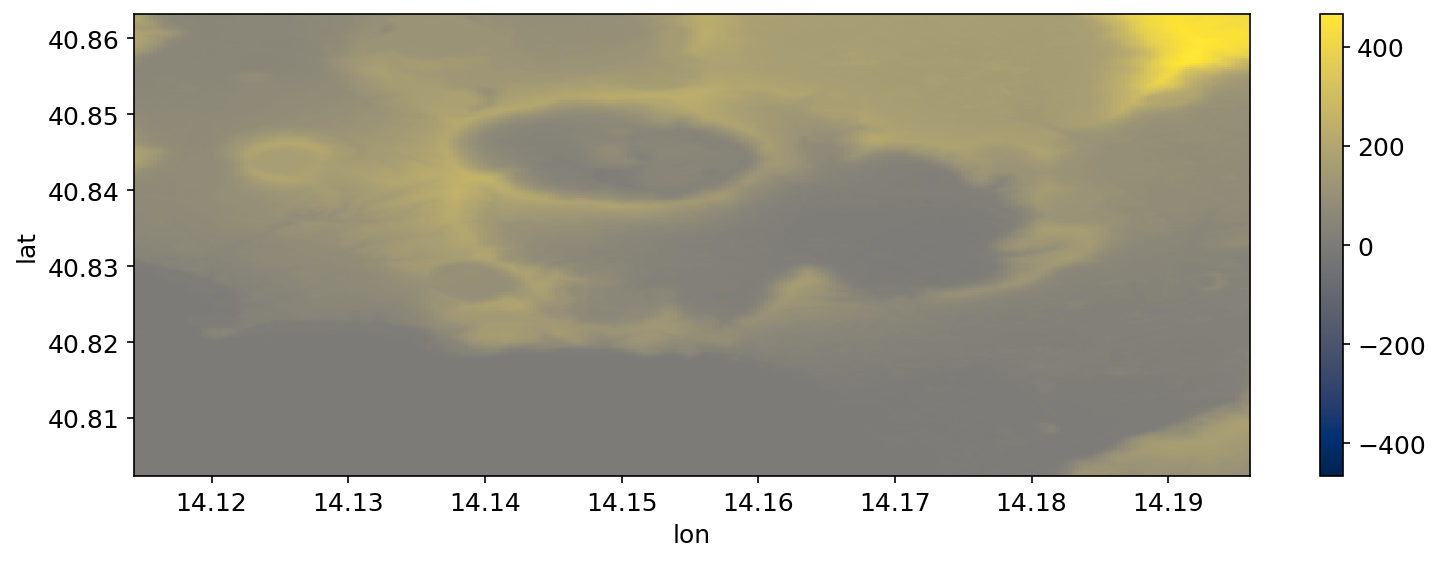

In [7]:
Tiles().download_dem_glo(AOI, filename=DEM,skip_exist=False).plot.imshow(cmap='cividis')

In [8]:
#Tiles().download_dem_glo(AOI, filename=DEM).plot.imshow(cmap='cividis')

In [9]:
if 'client' in globals():
        client.close()
client = Client()
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:38047
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38999'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36333'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33435', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33435
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:48310
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:39213', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker co

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38047,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:39213,Total threads: 1
Dashboard: http://127.0.0.1:38009/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:38999,


NOTE: auto set reference scene 2024-04-06. You can change it like Stack.set_reference("2022-01-20")


Reframing: 01...16 from 18:   0%|          | 0/16 [00:00<?, ?it/s]

Reframing: 17...18 from 18:   0%|          | 0/2 [00:00<?, ?it/s]

Save DEM on WGS84 Ellipsoid:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-d97def1e-b897-11ef-93e0-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:53370


Preparing Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/17 [00:00<?, ?it/s]

Radar Transform Computing:   0%|          | 0/1 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

INFO:distributed.scheduler:Receive client connection: Client-worker-633008a5-b898-11ef-93e3-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60956


Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

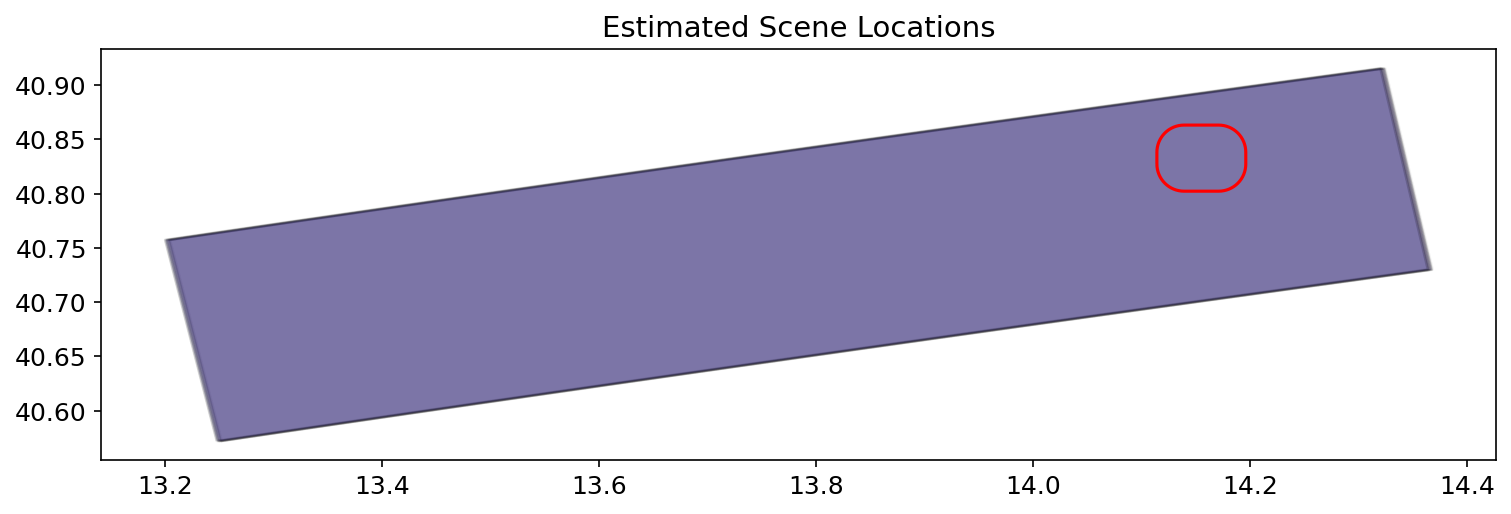

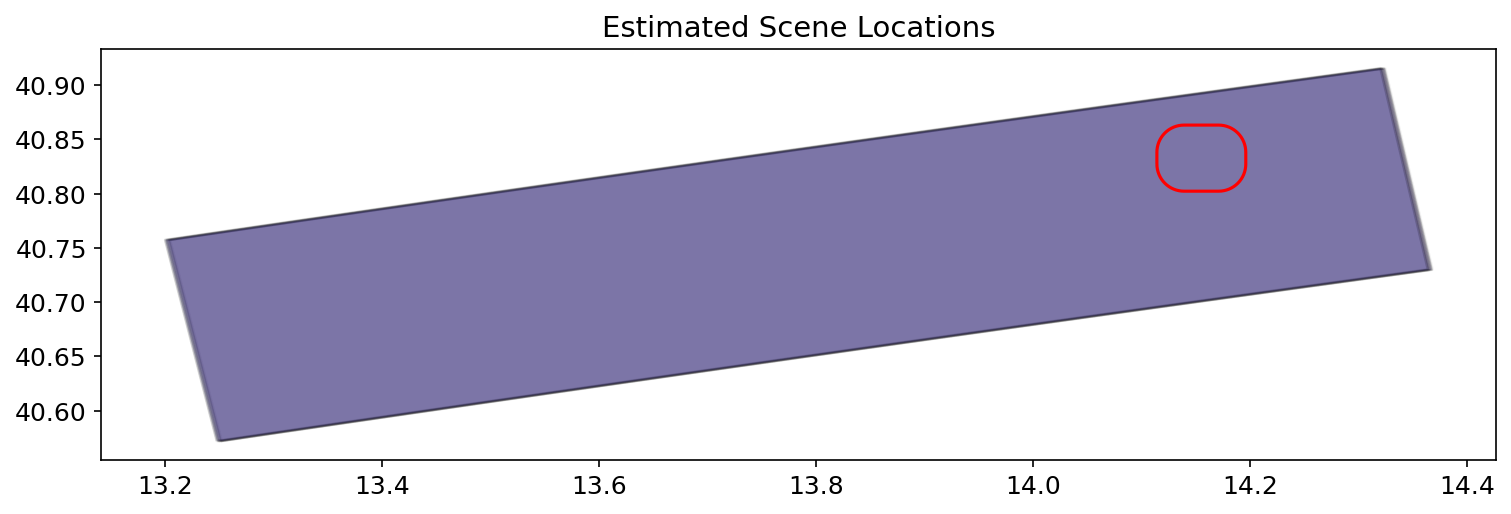

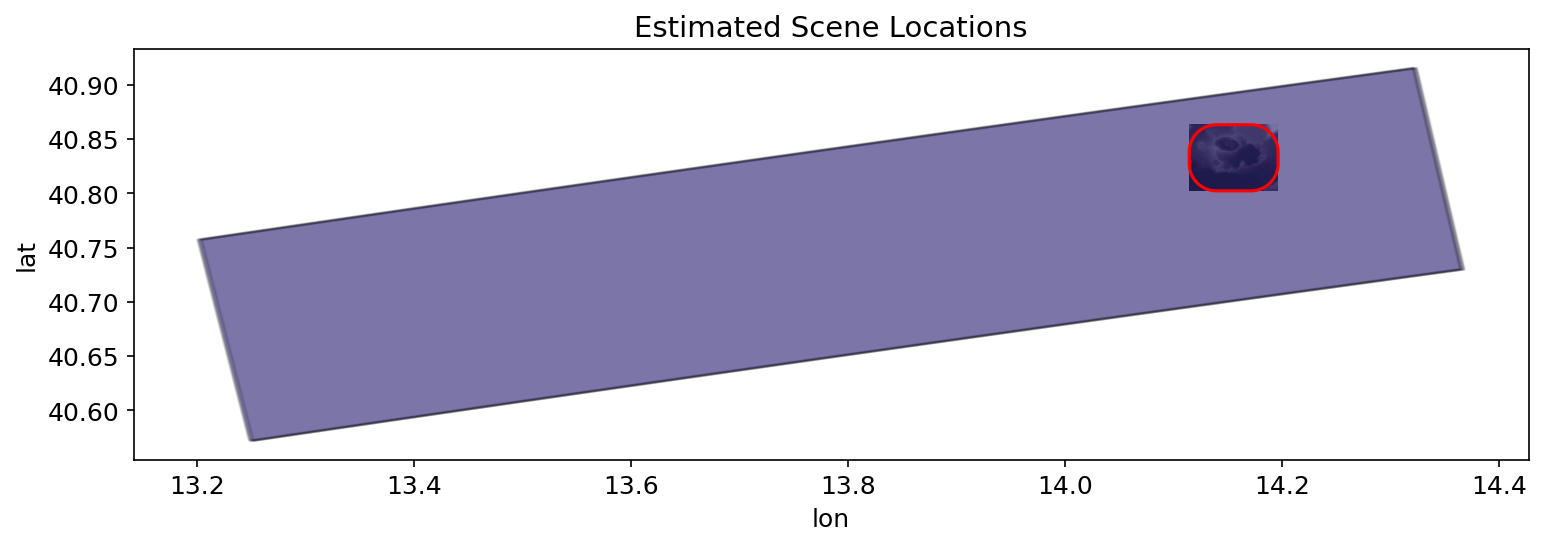

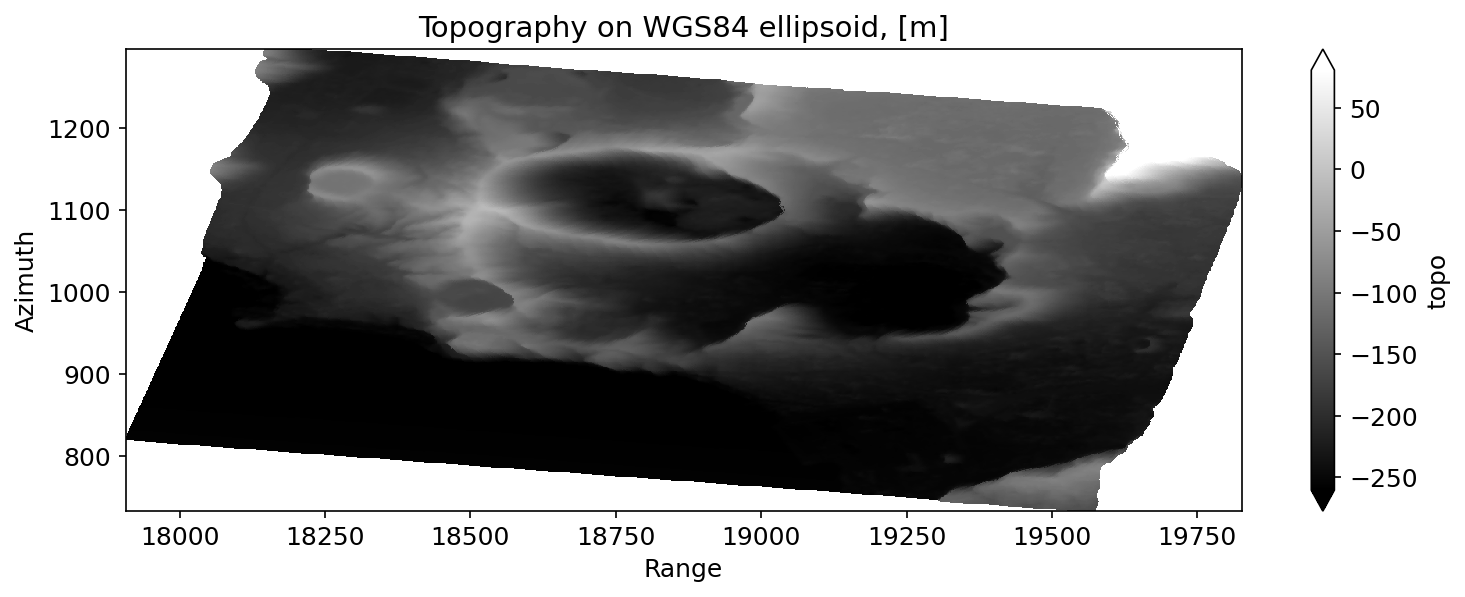

In [10]:
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH)

sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes).set_reference(REFERENCE)
sbas.to_dataframe()

sbas.plot_scenes(AOI=AOI)

sbas.compute_reframe(AOI)
sbas.plot_scenes(AOI=AOI)

    # define the area of interest (AOI) to speedup the processing
sbas.load_dem(DEM, AOI)
sbas.plot_scenes(AOI=AOI)

sbas.compute_align()

    # use the original Sentinel-1 resolution (1 pixel spacing)
sbas.compute_geocode(1)

sbas.plot_topo(quantile=[0.10, 0.99])




Intensity Normalization:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Compute Stability Measures:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

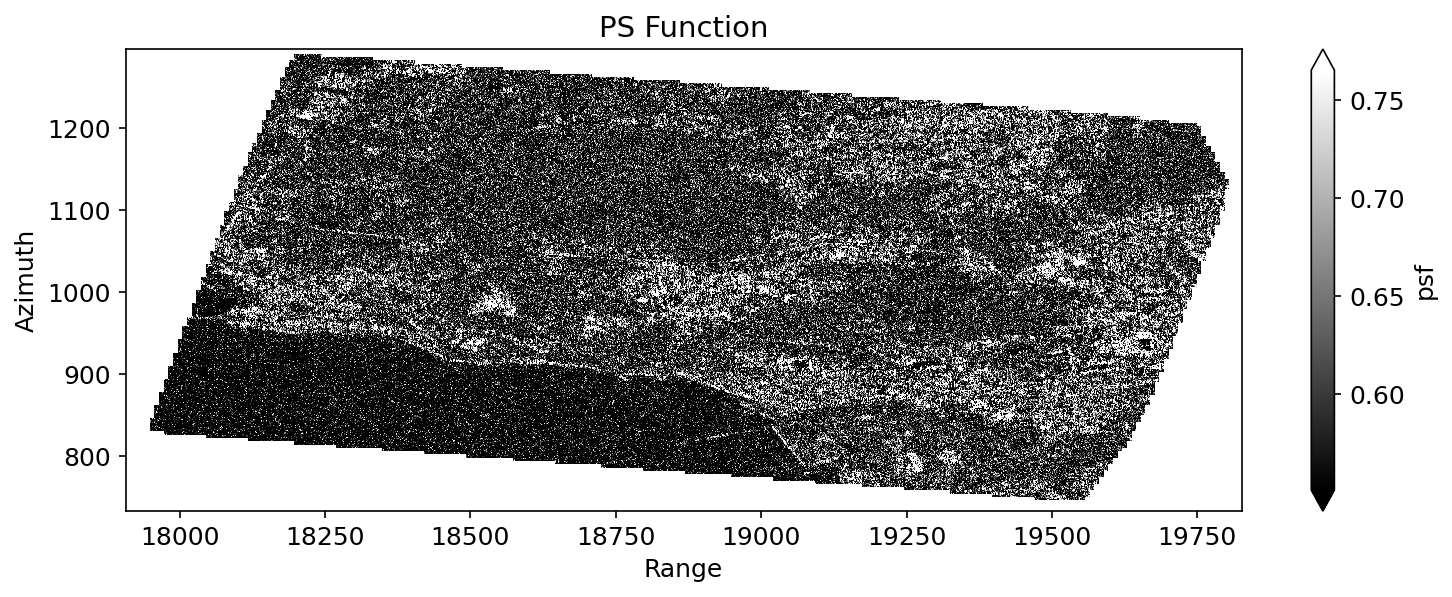

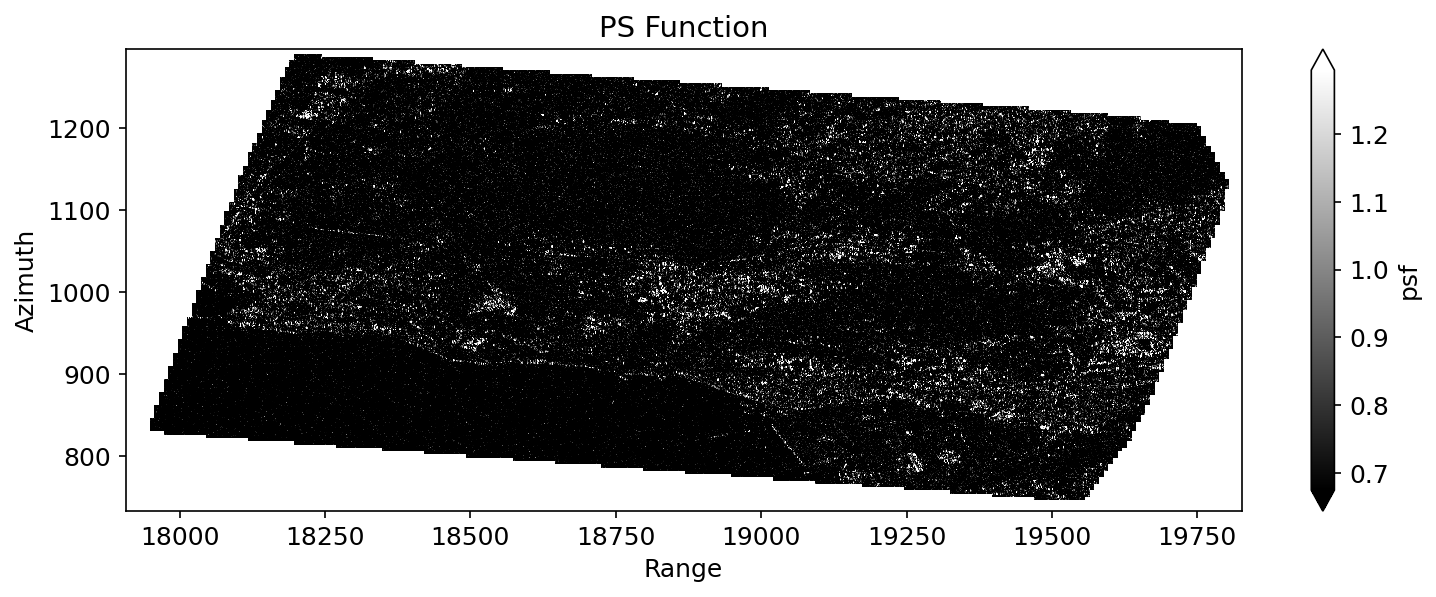

In [11]:
    # use the only selected dates for the pixels stability analysis
sbas.compute_ps()

sbas.plot_psfunction(quantile=[0.50, 0.90])

sbas.plot_psfunction(quantile=[0.80, 0.99])


In [12]:
baseline_pairs = sbas.sbas_pairs(days=24)
# optionally, drop dates having less then 2 pairs
#baseline_pairs = sbas.sbas_pairs_limit(baseline_pairs, limit=2, iterations=2)
# optionally, drop all pairs connected to the specified dates
#baseline_pairs = sbas.sbas_pairs_filter_dates(baseline_pairs, ['2021-01-01'])
baseline_pairs


,ref,rep,ref_baseline,rep_baseline,pair,baseline,duration,rel
0,2024-04-06,2024-04-18,-263.36,-246.27,2024-04-06 2024-04-18,17.09,12,NaT
1,2024-04-06,2024-04-30,-263.36,-228.95,2024-04-06 2024-04-30,34.41,24,NaT
2,2024-04-18,2024-04-30,-246.27,-228.95,2024-04-18 2024-04-30,17.32,12,NaT
3,2024-04-18,2024-05-12,-246.27,-113.79,2024-04-18 2024-05-12,132.48,24,NaT
4,2024-04-30,2024-05-12,-228.95,-113.79,2024-04-30 2024-05-12,115.16,12,NaT
5,2024-04-30,2024-05-24,-228.95,-80.32,2024-04-30 2024-05-24,148.63,24,NaT
6,2024-05-12,2024-05-24,-113.79,-80.32,2024-05-12 2024-05-24,33.47,12,NaT
7,2024-05-12,2024-06-05,-113.79,27.87,2024-05-12 2024-06-05,141.66,24,NaT
8,2024-05-24,2024-06-05,-80.32,27.87,2024-05-24 2024-06-05,108.19,12,NaT
9,2024-05-24,2024-06-17,-80.32,-59.34,2024-05-24 2024-06-17,20.98,24,NaT


In [13]:
sbas.compute_interferogram_multilook(baseline_pairs, 'intf_mlook', wavelength=30, weight=sbas.psfunction())

ds_sbas = sbas.open_stack('intf_mlook')
intf_sbas = ds_sbas.phase
corr_sbas = ds_sbas.correlation
corr_sbas

unwrap_sbas = sbas.unwrap_snaphu(intf_sbas, corr_sbas)
unwrap_sbas

decimator = sbas.decimator(resolution=15, grid=(1,1))
topo = decimator(sbas.get_topo())
inc = decimator(sbas.incidence_angle())
yy, xx = xr.broadcast(topo.y, topo.x)
trend_sbas = sbas.regression(unwrap_sbas.phase,
        [topo,    topo*yy,    topo*xx,    topo*yy*xx,
         topo**2, topo**2*yy, topo**2*xx, topo**2*yy*xx,
         topo**3, topo**3*yy, topo**3*xx, topo**3*yy*xx,
         inc,     inc**yy,    inc*xx,     inc*yy*xx,
         yy, xx,
         yy**2, xx**2, yy*xx,
         yy**3, xx**3, yy**2*xx, xx**2*yy], corr_sbas)

Saving Interferogram 01...16 from 33:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Saving Interferogram 17...32 from 33:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Saving Interferogram 33...33 from 33:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [15]:
# Calculate the PS function
ps_function = sbas.psfunction()

# Create a mask for pixels with weight between 0.80 and 0.99
ps_mask = (ps_function >= 0.80) & (ps_function <= 0.99)

# Apply the mask to the PS function for weighting
weighted_ps_function = ps_function.where(ps_mask)
sbas.compute_interferogram_singlelook(baseline_pairs, 'intf_slook', wavelength=30,
                                      weight=weighted_ps_function, phase=trend_sbas)

ds_ps = sbas.open_stack('intf_slook')
intf_ps = ds_ps.phase
corr_ps = ds_ps.correlation

disp_ps_pairs = sbas.los_displacement_mm(sbas.unwrap1d(intf_ps))
disp_ps_pairs

disp_ps = sbas.lstsq(disp_ps_pairs, corr_ps)
disp_ps

#disp_ps = sbas.sync_cube(disp_ps, 'disp_ps')



Saving Interferogram 01...16 from 33:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Saving Interferogram 17...32 from 33:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Saving Interferogram 33...33 from 33:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Note: data chunk size (inf, inf) is too large for stack processing
Note: auto tune data chunk size to a half of NetCDF chunk: (256, 256)
Note: data chunk size (inf, inf) is too large for stack processing
Note: auto tune data chunk size to a half of NetCDF chunk: (256, 256)


<xarray.DataArray 'displacement' (date: 18, y: 563, x: 1919)> Size: 78MB
dask.array<concatenate, shape=(18, 563, 1919), dtype=float32, chunksize=(18, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) datetime64[ns] 144B 2024-04-06 2024-04-18 ... 2024-10-27
  * y        (y) float64 5kB 733.5 734.5 735.5 ... 1.294e+03 1.294e+03 1.296e+03
  * x        (x) float64 15kB 1.791e+04 1.791e+04 ... 1.982e+04 1.983e+04

In [16]:
velocity_ps = sbas.velocity(disp_ps)
velocity_ps

<xarray.DataArray 'trend' (y: 563, x: 1919)> Size: 4MB
dask.array<mul, shape=(563, 1919), dtype=float32, chunksize=(32, 1919), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 5kB 733.5 734.5 735.5 ... 1.294e+03 1.294e+03 1.296e+03
  * x        (x) float64 15kB 1.791e+04 1.791e+04 ... 1.982e+04 1.983e+04
    degree   int64 8B 1

In [17]:
velocity_ps = sbas.sync_cube(velocity_ps, 'velocity_ps')


Syncing NetCDF 2D/3D Dataset:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Debugging information
---------------------
old task state: waiting
old run_spec: (<function execute_task at 0x7fbb4ea55870>, ((<function getitem at 0x7fbb301e1d80>, (<function concatenate3 at 0x7fbacf5a9120>, [[[('concatenate-1b1b75e37286d78d798f947b4359f68e', 31, 0, 0)]], [[('concatenate-1b1b75e37286d78d798f947b4359f68e', 32, 0, 0)]]]), (slice(0, 2, None), slice(256, 512, None), slice(1792, 1919, None))),), {})
new run_spec: (<function execute_task at 0x7fbb4ea55870>, ((<function getitem at 0x7fbb301e1d80>, (<function concatenate3 at 0x7fbacf5a9120>, [[[('concatenate-1b1b75e37286d78d798f947b4359f68e', 31, 0, 0)]], [[('concatenate-1b1b75e37286d78d798f947b4359f68e', 32, 0, 0)]]]), (slice(0, 2, None), slice(256, 512, None), slice(1536, 1792, None))),), {})
old token: ('tuple', (('913ceb5b5beb463a9010ec0790bc30002ca34164', []), ('tuple', (('tuple', (('0f86e61417c692901acfc59af936b6227b3cc6f8', []), ('tuple', (('9da048d2018d1157da638b81f5bffb3e31fbd9b3', []), ('list', (('list', (('list', 

In [ ]:

velocity_ps_ll = sbas.ra2ll(velocity_ps)
velocity_ps_ll = sbas.as_geo(velocity_ps_ll).rio.clip(AOI.geometry.buffer(-BUFFER))
sbas.export_vtk(velocity_ps_ll,   'velocity_ps', mask='auto')

gmap = XYZTiles().download(velocity_ps_ll, 15)
gmap.plot.imshow()
sbas.export_vtk(None, 'gmap', image=gmap, mask='auto')

In [ ]:
plotter = pv.Plotter(shape=(1, 1), notebook=True)
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

vtk_map = pv.read('gmap.vtk').scale([1, 1, 0.00002]).rotate_z(135)

vtk_grid = pv.read('velocity_ps.vtk').scale([1, 1, 0.00002]).rotate_z(135)
plotter.add_mesh(vtk_map.scale([1, 1, 0.999]), scalars='colors', rgb=True, ambient=0.2)
plotter.add_mesh(vtk_grid, scalars='trend', ambient=0.5, opacity=0.8, cmap='turbo_r',
                 clim=(-40,40), nan_opacity=0.8, nan_color='black',
                 show_scalar_bar=True)
plotter.show_axes()
plotter.add_title('PS LOS Velocity', font_size=32)

plotter.show_axes()
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=True, sizing_mode='stretch_width', min_height=600
)


In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import files

    files.download('velocity_ps.vtk')

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_ps, [0.10, 0.99])
#zminmax = max(abs(zmin), zmax)
zminmax = 40

ax = fig.add_subplot(1, 2, 1)
velocity_ps.plot.imshow(cmap='turbo_r', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.buffer(-BUFFER).boundary).plot(ax=ax)
#sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
#sbas.geocode(POI0).plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry.buffer(-BUFFER))\
    .plot.imshow(cmap='turbo_r', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.buffer(-BUFFER).boundary.plot(ax=ax)
#POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
#POI0.plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
#ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('PS LOS Velocity, 2023', fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=300)

zmin, zmax = np.nanquantile(velocity_ps, [0.70, 0.99])
zminmax = max(abs(zmin), zmax)

ax = fig.add_subplot(1, 2, 1)
velocity_ps.plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
sbas.geocode(AOI.buffer(-BUFFER).boundary).plot(ax=ax)
#sbas.geocode(POI).plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
#sbas.geocode(POI0).plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
ax.set_aspect('auto')
ax.set_title('Velocity, mm/year', fontsize=16)

ax = fig.add_subplot(1, 2, 2)
sbas.as_geo(sbas.ra2ll(velocity_ps)).rio.clip(AOI.geometry.buffer(-BUFFER))\
    .plot.imshow(cmap='turbo', vmin=-zminmax, vmax=zminmax, ax=ax)
AOI.buffer(-BUFFER).boundary.plot(ax=ax)
#POI.plot(ax=ax, marker='x', c='r', markersize=100, label='POI')
#POI0.plot(ax=ax, marker='x', c='b', markersize=100, label='POI$\Theta$')
#ax.legend(loc='upper left', fontsize=14)
ax.set_title('Velocity, mm/year', fontsize=16)

plt.suptitle('PS LOS Velocity, 2021', fontsize=18)
plt.tight_layout()
plt.show()